In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
X_train = np.load('data/X_train_augmented.npy')
Y_train = np.load('data/y_train_augmented.npy')

<Axes: ylabel='Density'>

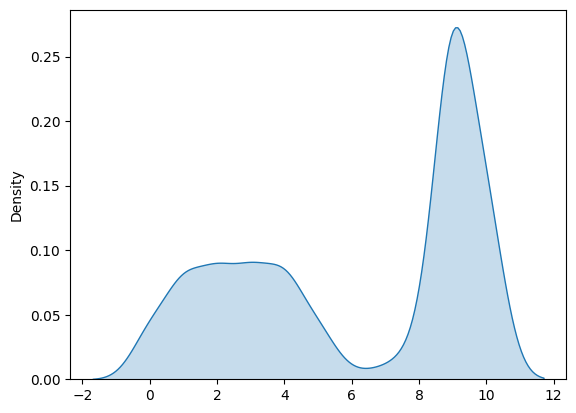

In [3]:
sns.kdeplot(Y_train, fill=True)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [5]:
from cuml import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [6]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"RMSE: {rmse}")

RMSE: 2.5921733379364014


In [7]:
from sklearn.ensemble import StackingRegressor
from sklearn.kernel_ridge import KernelRidge

In [8]:
base_estimators = [
    ('rf', RandomForestRegressor(random_state=42)),
]

meta_estimator = KernelRidge()

stacking_regressor = StackingRegressor(
    estimators=base_estimators,
    final_estimator=meta_estimator
)


In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 5, 10, 15],
    'rf__max_features': [None, 'sqrt', 'log2'],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False],
    'final_estimator__alpha': [0.1, 0.01, 0.001],
    'final_estimator__kernel': ['poly', 'rbf', 'sigmoid'],
    'final_estimator__degree': [2, 3, 4],
}



grid_search = GridSearchCV(
    estimator=stacking_regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


KeyboardInterrupt: 

In [ ]:
y_pred = best_model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"RMSE: {rmse}")

RMSE: 2.562333345413208


In [ ]:
X_test = np.load('data/X_test.npy')
y_test = best_model.predict(X_test)

In [29]:
y_test = np.clip(y_test, 0, 10)

In [18]:
df = pd.DataFrame({'ID': [i+1 for i in range(len(y_test))], 'score': np.round(y_test, 2)})
df.to_csv("submission.csv", index=False)

# Compare

<Axes: ylabel='Density'>

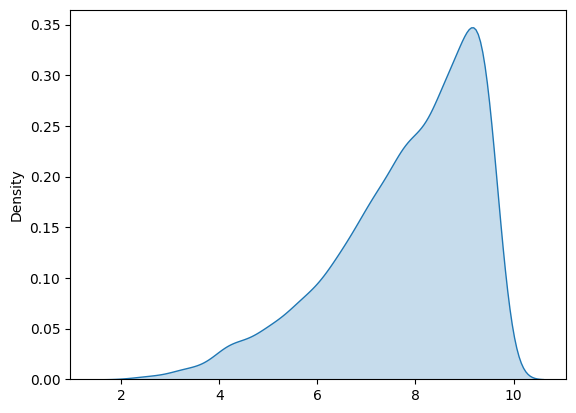

In [30]:
sns.kdeplot(y_test, fill=True)